In [332]:
import requests, math
import pandas as pd
from datetime import datetime
import statsmodels
from statsmodels.tsa.stattools import coint
import numpy as np
np.random.seed(107)
import matplotlib.pyplot as plt

In [285]:
def getHistory(symbol):
    r = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + symbol + "&outputsize=full&apikey=A0P4")
    r = r.json()['Time Series (Daily)']
    hist = []
    dates = []
    for key in r.keys():
        dates.append(datetime.strptime(key, '%Y-%m-%d'))
        row = [float(x) for x in list(r[key].values())]
        hist.append(row)
    hist.reverse()
    dates.reverse()
    out = pd.DataFrame.from_records(hist, index = dates, columns = ["Open", "High", "Low", "Close", "Volume"])
    '''change = pd.Series(None, index = out.index)
    for i in range(1, len(out)):
        change.iloc[i] = 100*(out['Close'].iloc[i]-out['Close'].iloc[i-1])/out['Close'].iloc[i-1]
    out['Change'] = change'''
    return out

In [286]:
a = "ADBE"
b = "MSFT"
a = getHistory(a)
b = getHistory(b)
a.head()

,Open,High,Low,Close,Volume
1998-01-02,40.88,40.88,39.50,40.50,797600.0
1998-01-05,40.13,41.63,40.13,41.06,1114600.0
1998-01-06,40.88,43.50,40.88,42.44,1579400.0
1998-01-07,42.38,42.50,41.38,41.81,2331700.0
1998-01-08,41.63,42.75,41.50,42.19,1106400.0


In [310]:
def addPercentColumn(x):
    close = x['Close'][start_date:]
    change = pd.Series(index = close.index)
    for i in range(len(close)):
        change.iloc[i] = 100*(close.iloc[i]-close.iloc[0])/close.iloc[0]
    x['Percent'] = change
    return x
a = addPercentColumn(a)
b = addPercentColumn(b)
a.head()

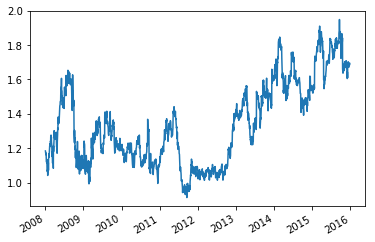

In [347]:
start_date = '2008-01-01'
end_date = '2016-01-01'
a = a[start_date:end_date]
b = b[start_date:end_date]
score, p, _ = coint(a['Close'], b['Close'])
ratio = a['Close']/b['Close']
ratio.plot()

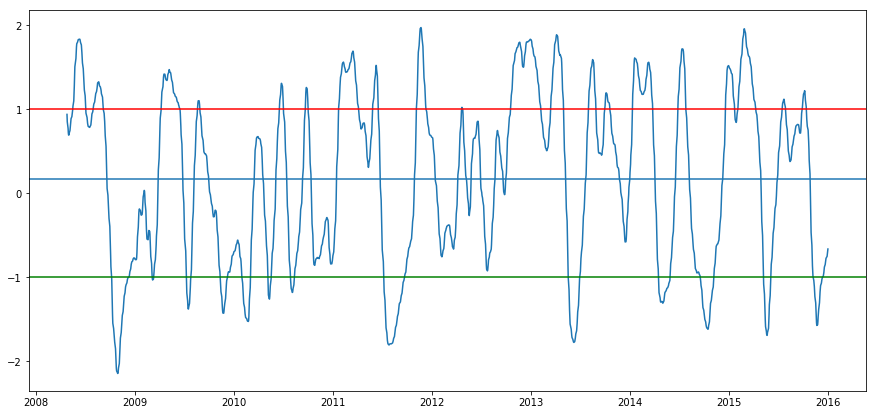

In [348]:
sma5 = ratio.rolling(center=False, window = 5).mean()[59:]
sma60 = ratio.rolling(center=False, window = 60).mean()[59:]
std60 = ratio.rolling(center=False, window = 60).std()[59:]
z = (sma5-sma60)/std60
z = z[start_date:].rolling(center=False, window = 20).mean()
plt.figure(figsize=(15,7))
plt.plot(z.index, z.values)
plt.axhline(z.mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [306]:
def crossover(i, a, b):
    #a crosses over b at i
    if a.iloc[i-1] < b.iloc[i-1] and a.iloc[i] > b.iloc[i]:
        return True
    else:
        return False
    
def crossunder(i, a, b):
    #a crosses under b at i
    if a.iloc[i-1] > b.iloc[i-1] and a.iloc[i] < b.iloc[i]:
        return True
    else:
        return False

In [350]:
overs = []
unders = []
for i in range(len(z)-1):
    date = z.index[i]    
    '''if crossunder(i, z, pd.Series(1, index = z.index)):
        unders.append(date)
    if crossover(i, z, pd.Series(-1, index = z.index)):
        overs.append(date)'''
    if z[date] > 1:
        unders.append(date)
    if z[date] < -1:
        overs.append(date)

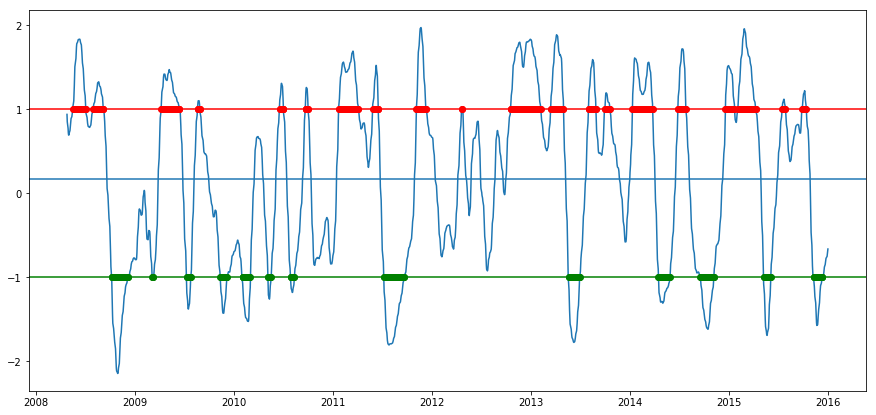

In [351]:
plt.figure(figsize=(15,7))
plt.plot(z.index, z.values)
plt.axhline(z.mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.plot(overs, [-1]*len(overs), 'go')
plt.plot(unders, [1]*len(unders), 'ro')
plt.show()

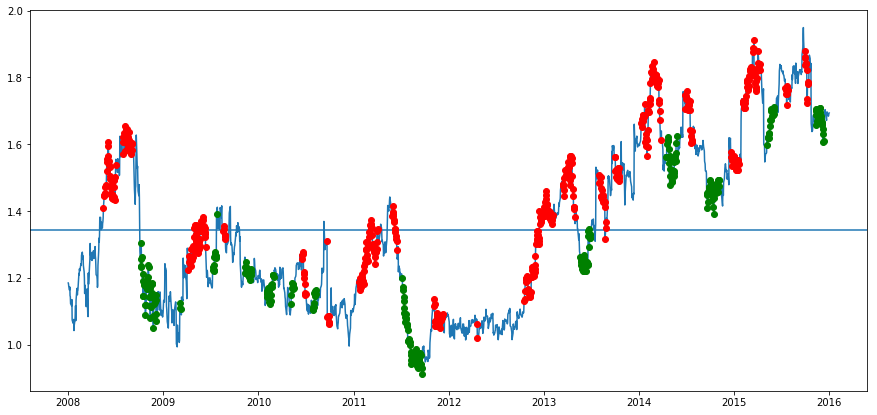

In [352]:
plt.figure(figsize=(15,7))
plt.plot(ratio.index, ratio.values)
plt.axhline(ratio.mean())
plt.plot(overs, [ratio[x] for x in overs], 'go')
plt.plot(unders, [ratio[x] for x in unders], 'ro')
plt.show()

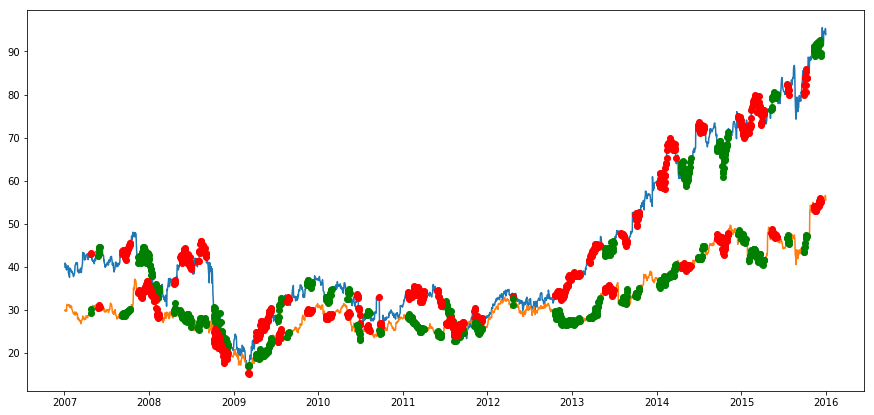

In [344]:
plt.figure(figsize=(15,7))
plt.plot(a.index, a['Close'].values)
plt.plot(b.index, b['Close'].values)
plt.plot(overs, [a['Close'][x] for x in overs], 'go')
plt.plot(overs, [b['Close'][x] for x in overs], 'ro')
plt.plot(unders, [a['Close'][x] for x in unders], 'ro')
plt.plot(unders, [b['Close'][x] for x in unders], 'go')
plt.show()

In [345]:
startingCash = 10000
cash = 10000
a_shares = 0
b_shares = 0
portfolio = pd.DataFrame(0, index = z.index, columns = ["Value", "Percent", "Long", "Short"])
for i in range(len(z.index)):
    date = z.index[i]
    if a_shares == 0 and b_shares == 0:
        if crossunder(i, z, pd.Series(1, index = z.index)):
            #short a, long b
            a_shares -= math.floor(cash/2/a['Close'][date])
            b_shares += math.floor(cash/2/b['Close'][date])
            cash = cash - b_shares*b['Close'][date] - a_shares*a['Close'][date] #negative shares accounts for shorting
        if crossover(i, z, pd.Series(-1, index = z.index)):
            #long a, short b
            a_shares += math.floor(cash/2/a['Close'][date])
            b_shares -= math.floor(cash/2/b['Close'][date])
            cash = cash - a_shares*a['Close'][date] - b_shares*b['Close'][date]
    else:
        if crossover(i, z, pd.Series(sma60[date], index=z.index)) or crossunder(i, z, pd.Series(sma60[date], index=z.index)):
            #close positions
            cash += a_shares*a['Close'][date] + b_shares*b['Close'][date]
            a_shares = 0
            b_shares = 0
        
    portfolioValue = cash + a_shares*a['Close'][date] + b_shares*b['Close'][date]
    portfolio["Value"][date] = portfolioValue
    portfolio["Percent"][date] = 100*(portfolioValue - startingCash)/startingCash
            

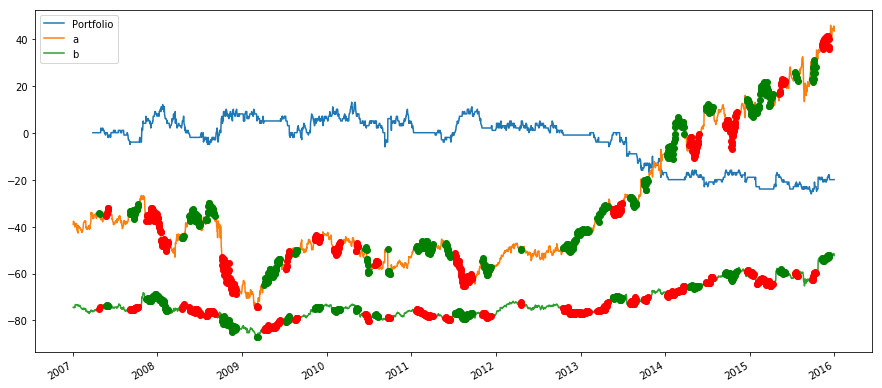

In [346]:
plt.figure(figsize=(15,7))
portfolio['Percent'].plot()
a['Percent'][start_date:].plot()
b['Percent'][start_date:].plot()
#red is short, green is long
plt.plot(overs, [a['Percent'][x] for x in overs], 'ro') #over is short a long b
plt.plot(overs, [b['Percent'][x] for x in overs], 'go')
plt.plot(unders, [a['Percent'][x] for x in unders], 'go') #over is short a long b
plt.plot(unders, [b['Percent'][x] for x in unders], 'ro')
plt.legend(['Portfolio', 'a', 'b'])